In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [48]:
# Config
aesthetic = False

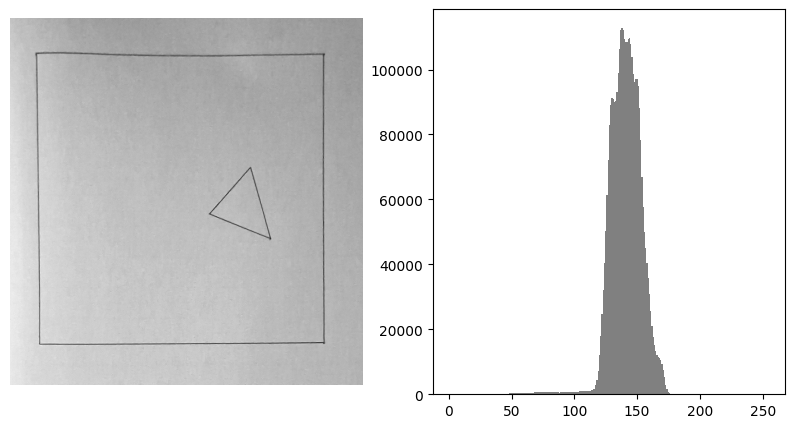

In [3]:
image_raw = "square.jpg"
image = cv2.imread(image_raw, cv2.IMREAD_GRAYSCALE)

fig, axes = plt.subplots(1,2 ,figsize=(10,5))
axes[0].imshow(image, cmap='gray')
axes[0].axis(False)
axes[1].hist(image.flatten(), bins=256, range=(0, 255), color='gray')

plt.show()

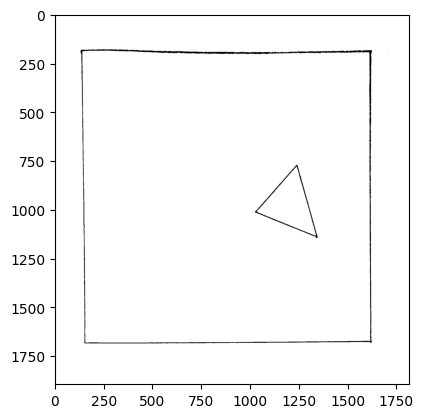

In [49]:
img_flat = image.flatten()

# red_img = np.zeros(image.shape)
# for i in image:
#     for j in i:
#         if j > 200:
#             red_img[i][j] = j
#         else:
#             red_img[i][j] = 0

red_img = np.where(image < 110, 0, 255)

if aesthetic == False:
    plt.imshow(red_img, cmap='gray')

if aesthetic == True:

    from io import BytesIO
    from IPython.display import display, Image

    mask = red_img == 0
    h, w = red_img.shape

    rgba = np.zeros((h, w, 4), dtype=float)

    # white lines
    rgba[..., 0] = 1
    rgba[..., 1] = 1
    rgba[..., 2] = 1
    rgba[..., 3] = mask.astype(float)

    # create transparent fig
    fig, ax = plt.subplots(figsize=(6,6))
    fig.patch.set_alpha(0)
    ax.set_facecolor((0,0,0,0))
    ax.imshow(rgba)
    ax.axis("off")

    # save to memory buffer instead of file
    buf = BytesIO()
    plt.savefig(buf, format="png", transparent=True, bbox_inches='tight', pad_inches=0)
    plt.close(fig)

    buf.seek(0)
    display(Image(buf.read()))



In [5]:
def norm_line(theta,x,y):
    theta_rad = np.deg2rad(theta)
    return x*np.cos(theta_rad) + y*np.sin(theta_rad)

H , W = red_img.shape

max_r = int(np.sqrt(H*H + W*W))
accumulator = np.zeros((2*max_r, 180))


for i in range(H):
    for j in range(W):

        row = []

        if red_img[i][j] == 0:

            for theta in range(180):
                r = norm_line(theta,j,i)
                r_index = int(r + max_r)
                accumulator[r_index][theta] += 1


In [ ]:
import plotly.graph_objects as go

theta_range = np.arange(0, 180)
rho_range = np.arange(-max_r, max_r)

log_acc = np.log(accumulator + 1)

fig = go.Figure(data=[go.Surface(
    z=accumulator,
    x=theta_range,
    y=rho_range,
    surfacecolor=log_acc,
    colorscale='Inferno',
    colorbar=dict(title='log(1 + Votes)')
)])

fig.update_layout(
    title='Hough Accumulator (3D)',
    scene=dict(
        xaxis_title='Theta (degrees)',
        yaxis_title='Rho',
        zaxis_title='Votes',
    ),
    width=900,
    height=700,
)

fig.show()

In [20]:
threshold = 300

lines = []
for r in range(2 * max_r):
    for t in range(180):
        if accumulator[r][t] > threshold:
            rho = r - max_r
            lines.append((accumulator[r][t], rho, t))

lines.sort(reverse=True)  # sort by votes descending
unique_lines = []

def is_same_line(rho1, t1, rho2, t2, rho_tol=100, theta_tol=25):
    if abs(rho1 - rho2) < rho_tol and abs(t1 - t2) < theta_tol:
        return True
    if abs(rho1 + rho2) < rho_tol and (180 - abs(t1 - t2)) < theta_tol:
        return True
    return False

for (votes, rho, theta) in lines:
    keep = True
    for (v2, r2, t2) in unique_lines:
        if is_same_line(rho, theta, r2, t2):
            keep = False
            break
    if keep:
        unique_lines.append((votes, rho, theta))

print(f"Detected {len(unique_lines)} lines:")
for (votes, rho, theta) in unique_lines:
    print(f"  Rho: {rho}, Theta: {theta}, Votes: {int(votes)}")

Detected 7 lines:
  Rho: 1614, Theta: 0, Votes: 1499
  Rho: 196, Theta: 90, Votes: 1041
  Rho: 1683, Theta: 90, Votes: 940
  Rho: -132, Theta: 179, Votes: 854
  Rho: -976, Theta: 164, Votes: 403
  Rho: 555, Theta: 112, Votes: 358
  Rho: 1440, Theta: 41, Votes: 343


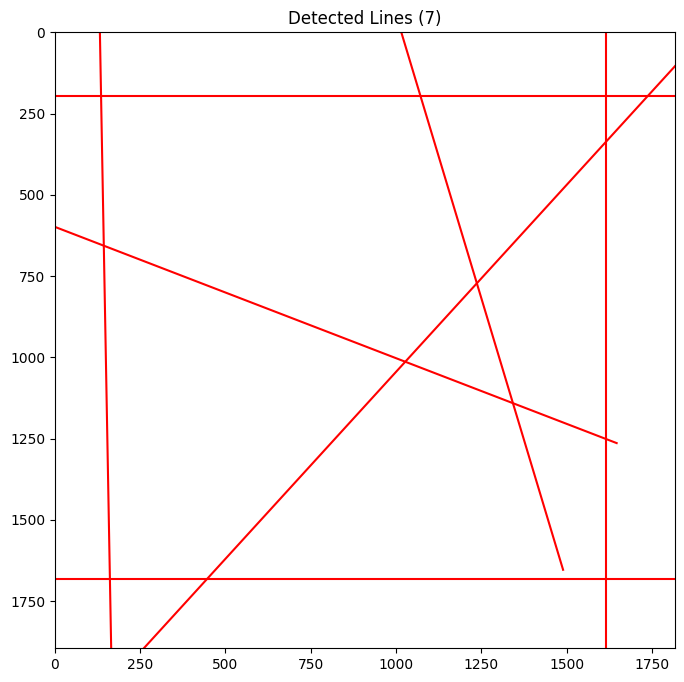

In [21]:
# Draw detected lines on an empty plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, W)
ax.set_ylim(H, 0)  # flip y-axis to match image coordinates

for (votes, rho, theta_deg) in unique_lines:
    theta_rad = np.deg2rad(theta_deg)
    cos_t = np.cos(theta_rad)
    sin_t = np.sin(theta_rad)

    x0 = cos_t * rho
    y0 = sin_t * rho

    x1 = x0 + 2000 * (-sin_t)
    y1 = y0 + 2000 * (cos_t)
    x2 = x0 - 2000 * (-sin_t)
    y2 = y0 - 2000 * (cos_t)

    ax.plot([x1, x2], [y1, y2], 'r-')

ax.set_title(f"Detected Lines ({len(unique_lines)})")
plt.show()

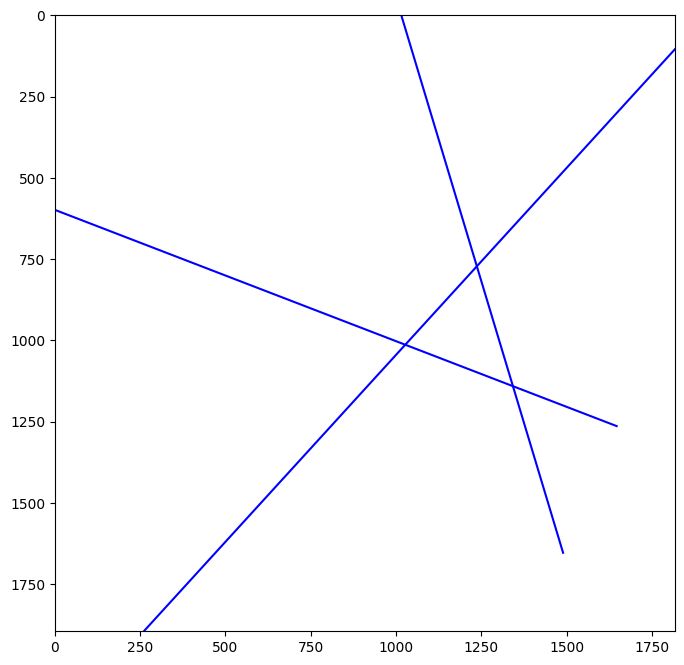

In [22]:
triangle_lines = []
square_lines = []

for (votes, rho, theta_deg) in unique_lines:
    if (abs(theta_deg - 90) < 10) or (abs(theta_deg) < 10) or (abs(theta_deg - 180) < 10):
        square_lines.append((votes, rho, theta_deg))
    else:
        triangle_lines.append((votes, rho, theta_deg))

triangle_line_points = []

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, W)
ax.set_ylim(H, 0)  # flip y-axis to match image coordinates
for (votes, rho, theta_deg) in triangle_lines:
    theta_rad = np.deg2rad(theta_deg)
    cos_t = np.cos(theta_rad)
    sin_t = np.sin(theta_rad)

    x0 = cos_t * rho
    y0 = sin_t * rho

    x1 = x0 + 2000 * (-sin_t)
    x2 = x0 - 2000 * (-sin_t)

    y1 = y0 + 2000 * (cos_t)
    y2 = y0 - 2000 * (cos_t)

    triangle_line_points.append(((x1, y1), (x2, y2)))

    ax.plot([x1, x2], [y1, y2], 'b-')

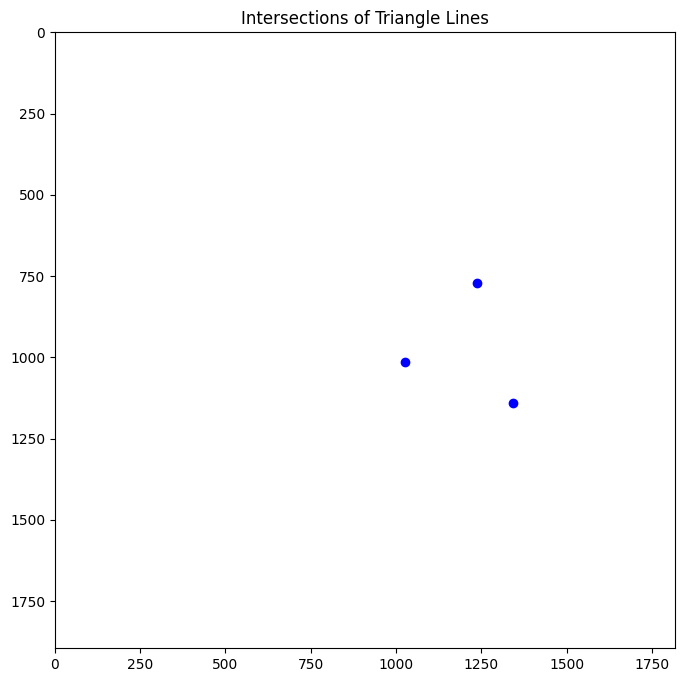

In [23]:

def line(x,m,c):
    return m*x + c

def fit_line(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    if x2 - x1 == 0:
        m = float('inf')
        c = x1
    else:
        m = (y2 - y1) / (x2 - x1)
        c = y1 - m * x1
    return m, c

intersections = []

for i in range(len(triangle_line_points)):
    for j in range(i+1, len(triangle_line_points)):
        p1, p2 = triangle_line_points[i]
        p3, p4 = triangle_line_points[j]
        
        m1, c1 = fit_line(p1, p2)
        m2, c2 = fit_line(p3, p4)
        

        x_intersect = (c2 - c1) / (m1 - m2)
        y_intersect = line(x_intersect, m1, c1)
        
        intersections.append((x_intersect, y_intersect))


# plot the interseciton points
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, W)
ax.set_ylim(H, 0)  # flip y-axis to match image coordinates
for (x, y) in intersections:
    ax.plot(x, y, 'o', color='blue')
ax.set_title(f"Intersections of Triangle Lines")
plt.show()

In [43]:
def area_coordinates(x1, y1, x2, y2, x3, y3):
  """Calculates the area of a triangle given its vertices' coordinates."""
  area = 0.5 * abs(x1 * (y2 - y3) + x2 * (y3 - y1) + x3 * (y1 - y2))
  return area

print(triangle_line_points)

triangle_pixel_area = area_coordinates(intersections[0][0], intersections[0][1],
                                     intersections[1][0], intersections[1][1],
                                     intersections[2][0], intersections[2][1])

print(triangle_pixel_area)

[((np.float64(386.9167036018008), np.float64(-2191.5454511540293)), (np.float64(1489.4661268697978), np.float64(1653.5013325992466))), ((np.float64(-2062.274368479406), np.float64(-234.62614754725712)), (np.float64(1646.4610497877436), np.float64(1263.800226116391))), ((np.float64(-225.33626246022277), np.float64(2454.144162191875)), (np.float64(2398.8998535018063), np.float64(-564.6941586992136)))]
51441.45545930465


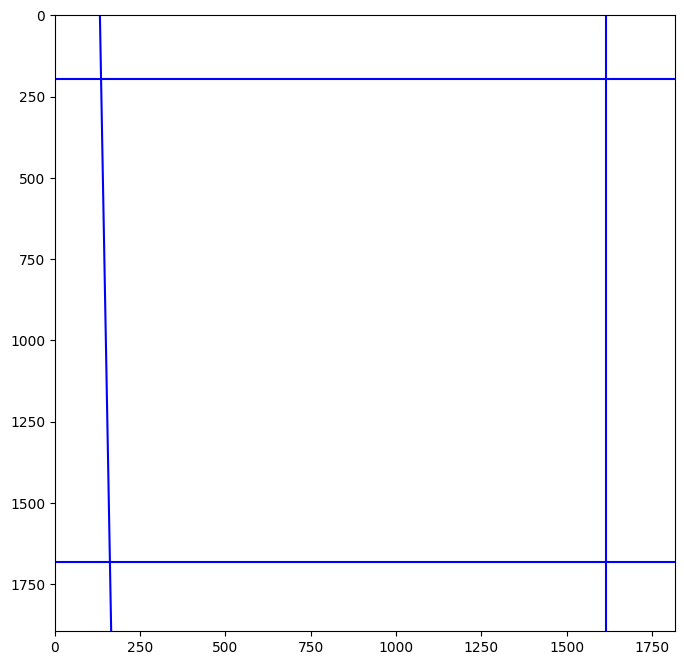

In [25]:
square_line_points = []

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, W)
ax.set_ylim(H, 0)  # flip y-axis to match image coordinates
for (votes, rho, theta_deg) in square_lines:
    theta_rad = np.deg2rad(theta_deg)
    cos_t = np.cos(theta_rad)
    sin_t = np.sin(theta_rad)

    x0 = cos_t * rho
    y0 = sin_t * rho

    x1 = x0 + 2000 * (-sin_t)
    x2 = x0 - 2000 * (-sin_t)

    y1 = y0 + 2000 * (cos_t)
    y2 = y0 - 2000 * (cos_t)

    square_line_points.append(((x1, y1), (x2, y2)))

    ax.plot([x1, x2], [y1, y2], 'b-')

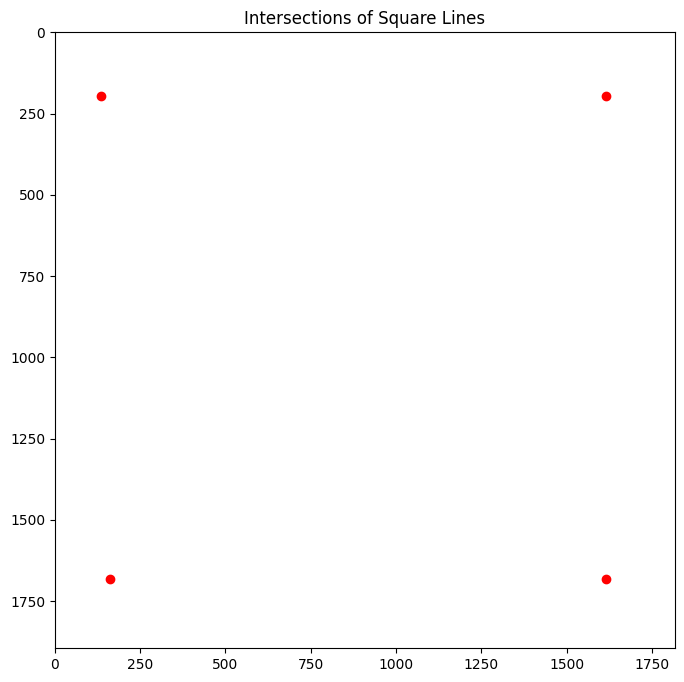

In [36]:
intersections_square = []

for i in range(len(square_line_points)):
    for j in range(i+1, len(square_line_points)):
        p1, p2 = square_line_points[i]
        p3, p4 = square_line_points[j]

        m1, c1 = fit_line(p1, p2)
        m2, c2 = fit_line(p3, p4)

        if m1 == m2:
            continue  # parallel lines, no intersection

        if m1 == float('inf'):
            x_intersect = c1
            y_intersect = line(x_intersect, m2, c2)
        elif m2 == float('inf'):
            x_intersect = c2
            y_intersect = line(x_intersect, m1, c1)
        else:
            x_intersect = (c2 - c1) / (m1 - m2)
            y_intersect = line(x_intersect, m1, c1)

        # keep only intersections within image bounds
        if 0 <= x_intersect <= W and 0 <= y_intersect <= H:
            intersections_square.append((x_intersect, y_intersect))

# plot the intersection points
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlim(0, W)
ax.set_ylim(H, 0)
for (x, y) in intersections_square:
    ax.plot(x, y, 'o', color='red')
ax.set_title("Intersections of Square Lines")
plt.show()

In [44]:
def distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

print(intersections_square)

print(f'Length in pixel of the square sides: {distance(intersections_square[2], intersections_square[3])}')

[(np.float64(1614.0), np.float64(195.99999999999991)), (np.float64(1614.0), np.float64(1682.9999999999998)), (np.float64(135.44130002772644), np.float64(196.0)), (np.float64(161.3969815759859), np.float64(1683.0))]
Length in pixel of the square sides: 1487.2265118012906


In [45]:
pixel_square_length = distance(intersections_square[2], intersections_square[3])
real_square_length = 15  # cm

multiplier = real_square_length / pixel_square_length

real_triangle_area = triangle_pixel_area * (multiplier ** 2)

print(f"Real triangle area in cm^2: {real_triangle_area:.2f}")


Real triangle area in cm^2: 5.23
